In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
import sys
!pip install torchaudio comet-ml==3.0.2 torchvision==0.6.0

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset
import torchaudio
import librosa
import pandas as pd
import numpy as np
import time
import os
from tqdm.notebook import tqdm
import copy

In [5]:
path_to_data = "/content/gdrive/My Drive/Research/truncted_dataset_2"

In [6]:
data_transform_augmentations = transforms.Compose([
            transforms.Resize((224, 224)), # Вообще в официальном туториале говорится, что надо минимум 224 размер, но я оставил как у нас было и вроде работает
            transforms.RandomApply([
                transforms.RandomResizedCrop((224,224)),
            ],0.6),     
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])

data_transform = transforms.Compose([
            transforms.Resize((224, 224)), # Вообще в официальном туториале говорится, что надо минимум 224 размер, но я оставил как у нас было и вроде работает
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),])

tranforms = {'augmentation' : data_transform_augmentations, 'original' : data_transform}

In [7]:
dataset = datasets.ImageFolder(root=path_to_data,
                              transform=tranforms['original'])

In [8]:
dataset.class_to_idx

{'down': 0,
 'go': 1,
 'left': 2,
 'no': 3,
 'off': 4,
 'on': 5,
 'right': 6,
 'stop': 7,
 'unknown': 8,
 'up': 9,
 'yes': 10}

In [9]:
n = len(dataset.samples)
dataset_sizes = {'train' : int(n*0.7), 'val' : int(n*0.3) + 1}
train_set, val_set = torch.utils.data.random_split(dataset, [dataset_sizes['train'], dataset_sizes['val']])
loader_train = torch.utils.data.DataLoader(train_set,
                                              batch_size=256, shuffle=True,
                                              num_workers=4)
loader_val = torch.utils.data.DataLoader(val_set,
                                              batch_size=256, shuffle=True,
                                              num_workers=4)
dataloaders = {'train' : loader_train, 'val' : loader_val}

In [10]:
model = models.resnet34(pretrained=True)
# replace the last layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 11)

criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs).to(device)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]
            
            train_state[phase + '_acc'].append(epoch_acc)
            train_state[phase + '_loss'].append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                if best_acc.item() > 0.63:
                    best_model_path = '/content/gdrive/My Drive/Research/TFchallenge/best_model.pth'
                    torch.save(best_model_wts, best_model_path)
        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model, best_acc

In [ ]:
train_state = {'train_loss' : [], 'train_acc' : [], 'val_loss' : [], 'val_acc' : []}
if torch.cuda.is_available():
    model.cuda()
#last_best_mod = '/content/gdrive/My Drive/Research/TFchallenge/res_net_model_tensor(0.9630).pth'
#model.load_state_dict(torch.load(last_best_mod))
model_ret, best_acc = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)
# save model
best_model_path = '/content/gdrive/My Drive/Research/TFchallenge/res_net_model_full' + str(best_acc.item()) + '.pth'
torch.save(model_ret.state_dict(), best_model_path)

Epoch 0/29
----------
Iterating through data...


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



train Loss: 0.3729 Acc: 0.8778
Iterating through data...



val Loss: 0.2553 Acc: 0.9160

Epoch 1/29
----------
Iterating through data...



train Loss: 0.1326 Acc: 0.9572
Iterating through data...



val Loss: 0.4793 Acc: 0.8657

Epoch 2/29
----------
Iterating through data...



train Loss: 0.1075 Acc: 0.9649
Iterating through data...



val Loss: 0.1805 Acc: 0.9405

Epoch 3/29
----------
Iterating through data...



train Loss: 0.0825 Acc: 0.9733
Iterating through data...



val Loss: 0.1784 Acc: 0.9455

Epoch 4/29
----------
Iterating through data...



train Loss: 0.0686 Acc: 0.9776
Iterating through data...



val Loss: 0.1458 Acc: 0.9540

Epoch 5/29
----------
Iterating through data...



train Loss: 0.0590 Acc: 0.9810
Iterating through data...



val Loss: 0.1955 Acc: 0.9432

Epoch 6/29
----------
Iterating through data...



train Loss: 0.0356 Acc: 0.9888
Iterating through data...



val Loss: 0.0832 Acc: 0.9749

Epoch 7/29
----------
Iterating through data...



train Loss: 0.0241 Acc: 0.9923
Iterating through data...



val Loss: 0.0825 Acc: 0.9758

Epoch 8/29
----------
Iterating through data...



train Loss: 0.0201 Acc: 0.9935
Iterating through data...



val Loss: 0.0817 Acc: 0.9761

Epoch 9/29
----------
Iterating through data...



train Loss: 0.0168 Acc: 0.9947
Iterating through data...



val Loss: 0.0855 Acc: 0.9769

Epoch 10/29
----------
Iterating through data...



train Loss: 0.0128 Acc: 0.9961
Iterating through data...



val Loss: 0.0885 Acc: 0.9769

Epoch 11/29
----------
Iterating through data...



train Loss: 0.0097 Acc: 0.9969
Iterating through data...



val Loss: 0.0923 Acc: 0.9778

Epoch 12/29
----------
Iterating through data...



train Loss: 0.0066 Acc: 0.9983
Iterating through data...



val Loss: 0.0960 Acc: 0.9778

Epoch 13/29
----------
Iterating through data...



train Loss: 0.0038 Acc: 0.9993
Iterating through data...



val Loss: 0.0996 Acc: 0.9774

Epoch 14/29
----------
Iterating through data...



train Loss: 0.0035 Acc: 0.9992
Iterating through data...



val Loss: 0.0990 Acc: 0.9778

Epoch 15/29
----------
Iterating through data...



train Loss: 0.0032 Acc: 0.9994
Iterating through data...



val Loss: 0.1000 Acc: 0.9783

Epoch 16/29
----------
Iterating through data...



train Loss: 0.0027 Acc: 0.9997
Iterating through data...



val Loss: 0.1011 Acc: 0.9779

Epoch 17/29
----------
Iterating through data...



train Loss: 0.0025 Acc: 0.9996
Iterating through data...



val Loss: 0.1020 Acc: 0.9777

Epoch 18/29
----------
Iterating through data...



train Loss: 0.0022 Acc: 0.9997
Iterating through data...



val Loss: 0.1032 Acc: 0.9779

Epoch 19/29
----------
Iterating through data...



train Loss: 0.0022 Acc: 0.9997
Iterating through data...



val Loss: 0.1038 Acc: 0.9775

Epoch 20/29
----------
Iterating through data...


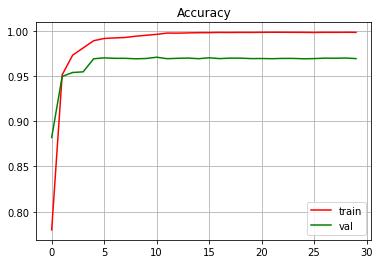

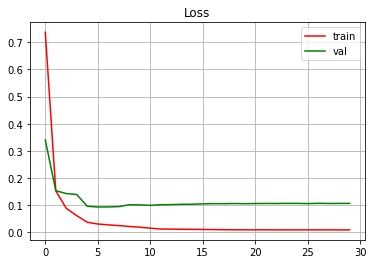

In [ ]:
from matplotlib import pyplot as plt
def draw(train_state):
    plt.title('Accuracy')
    train_acc = plt.plot(train_state['train_acc'], 'r-', label='train')
    val_acc = plt.plot(train_state['val_acc'], 'g-', label='val')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.title('Loss')
    train_loss = plt.plot(train_state['train_loss'], 'r-', label='train')
    val_loss = plt.plot(train_state['val_loss'], 'g-', label='val')
    plt.legend()
    plt.grid(True)
    plt.show()

draw(train_state)

In [ ]:
# load model
best_model = models.resnet18(pretrained=True)
# replace the last layer
num_features = model.fc.in_features
best_model.fc = nn.Linear(num_features, 11)
best_model.load_state_dict(torch.load(best_model_path))
best_model.eval()

In [ ]:
# helper function
from PIL import Image
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [ ]:
data_dir = '/content/gdrive/My Drive/Research/truncted_dataset/'
classes = os.listdir(data_dir)
classes

['yes',
 'up',
 'go',
 'on',
 'off',
 'left',
 'right',
 'down',
 'unknown',
 'no',
 '_background_noise_']